In [1]:
import os 
import numpy as np
np.seterr(divide = "ignore")
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## ** LOAD DATA **

In [2]:
dataDir = "E:/pythonProgramming/machineLearning_Project/Bank Loan Prediction/DS1"
dataTrain = pd.read_csv(os.path.join(dataDir, "app_train.csv"))
dataTest = pd.read_csv(os.path.join(dataDir, "app_test.csv"))

## ** DATA PREPROCESSING **

In [3]:
# ====== REMOVE UNIDENTIFIED FEATURE

dataTrain.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dataTrain.drop(["a"], axis=1, inplace=True)

dataTest.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dataTest.drop(["a"], axis=1, inplace=True)

In [4]:
# ====== HANDLE CATEGORICAL FEATURE
# Get the name of categorically features
categDataTrain = dataTrain.select_dtypes(include="object")
categFeatures = categDataTrain.columns

In [5]:
from sklearn.preprocessing import LabelEncoder

def replaceCategValues(data, categFeatures):
    lb = LabelEncoder()
    for feature in categFeatures:
        data[feature] = lb.fit_transform(data[feature])
    return data

In [6]:
dataTrain = replaceCategValues(dataTrain, categFeatures)
dataTest = replaceCategValues(dataTest, categFeatures)

fullData = pd.concat([dataTrain, dataTest], ignore_index=True)

Text(0.5, 1.0, 'Training Data')

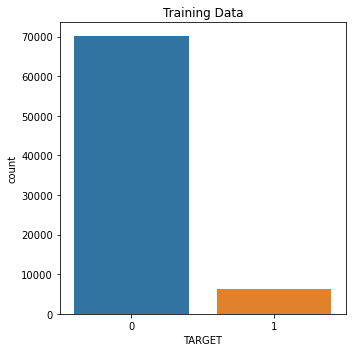

In [7]:
# ====== HANDLE IMBALANCED DATA

import seaborn as sns

plt.figure(1, figsize=(5,5), tight_layout=True)
g1 = sns.countplot(fullData.TARGET)

g1.set_title("Training Data")

In [8]:
#  ====== random under-sampling
def randUnderSampling(data, targetColumn):
    targetCount = data[targetColumn].value_counts()
    for i in targetCount.index:
        if targetCount[i] == min(targetCount):
            continue
        print('Abundant class {} = {}'.format(targetCount.index[i], targetCount[i]))
        frac = min(targetCount)/targetCount[i]
        abundantClass = data[data[targetColumn] == i]
        index = abundantClass.sample(frac=1-frac, random_state=0).index
        data.drop(index, inplace=True)
    print('\nRandom Under-Sampling:')
    print(data[targetColumn].value_counts())
    return data

In [9]:
fullData = randUnderSampling(fullData, targetColumn="TARGET")

Abundant class 0 = 70092

Random Under-Sampling:
1    6172
0    6172
Name: TARGET, dtype: int64


In [10]:
# ====== HANDLE MISSING VALUES

isnullData = fullData.isnull()
for feature in isnullData.keys():
    if isnullData[feature].value_counts()[False] == isnullData.shape[0]:
        continue
    print(isnullData[feature].value_counts())

False    12330
True        14
Name: PRICE, dtype: int64
True     7166
False    5178
Name: EXT_SCORE_1, dtype: int64
False    12323
True        21
Name: EXT_SCORE_2, dtype: int64
False    9740
True     2604
Name: EXT_SCORE_3, dtype: int64


In [11]:
# fill missing value with mean of each feature
fullData.fillna(fullData.mean(), inplace=True)

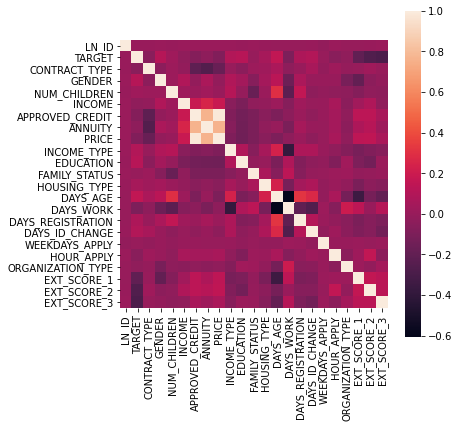

In [12]:
f,ax = plt.subplots(1, 1, figsize=(6,6))
sns.heatmap(fullData.corr(), square=True)

In [13]:
X_data = fullData.drop(["LN_ID"], axis=1)

In [14]:
import math
def plotDataDistribute(data):
    row = math.ceil(len(data.columns)/4)

    plt.figure(1, figsize=(15, 15), tight_layout=True)
    for feature, i in zip(data.columns, range(len(data.columns))):
        ax = plt.subplot(row, 4, i+1)
        sns.distplot(data[feature], ax=ax)
        ax.set_title(feature)

Plot Original Data


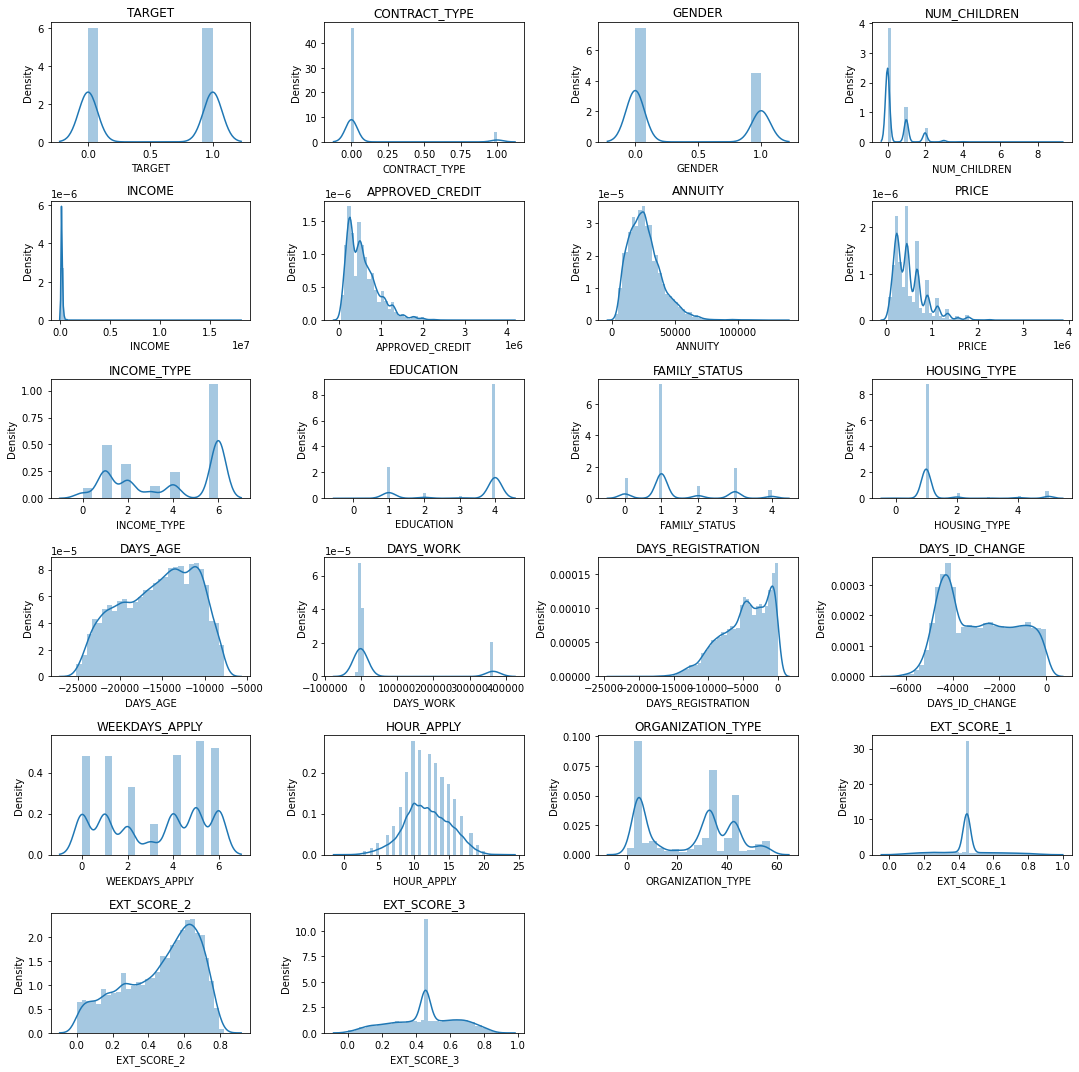

In [15]:
print("Plot Original Data")
plotDataDistribute(X_data)

In [16]:
# ====== HANDLE SCALLING AND NORMALIZATION
# scaling data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
# scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_data)
scaled_X = pd.DataFrame(scaled_X, columns=X_data.columns)

In [17]:
# normalize data
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(standardize=False)
norm_X = pt.fit_transform(scaled_X)
norm_X = pd.DataFrame(norm_X, columns=X_data.columns)

Plot Scaled and Normalize Data


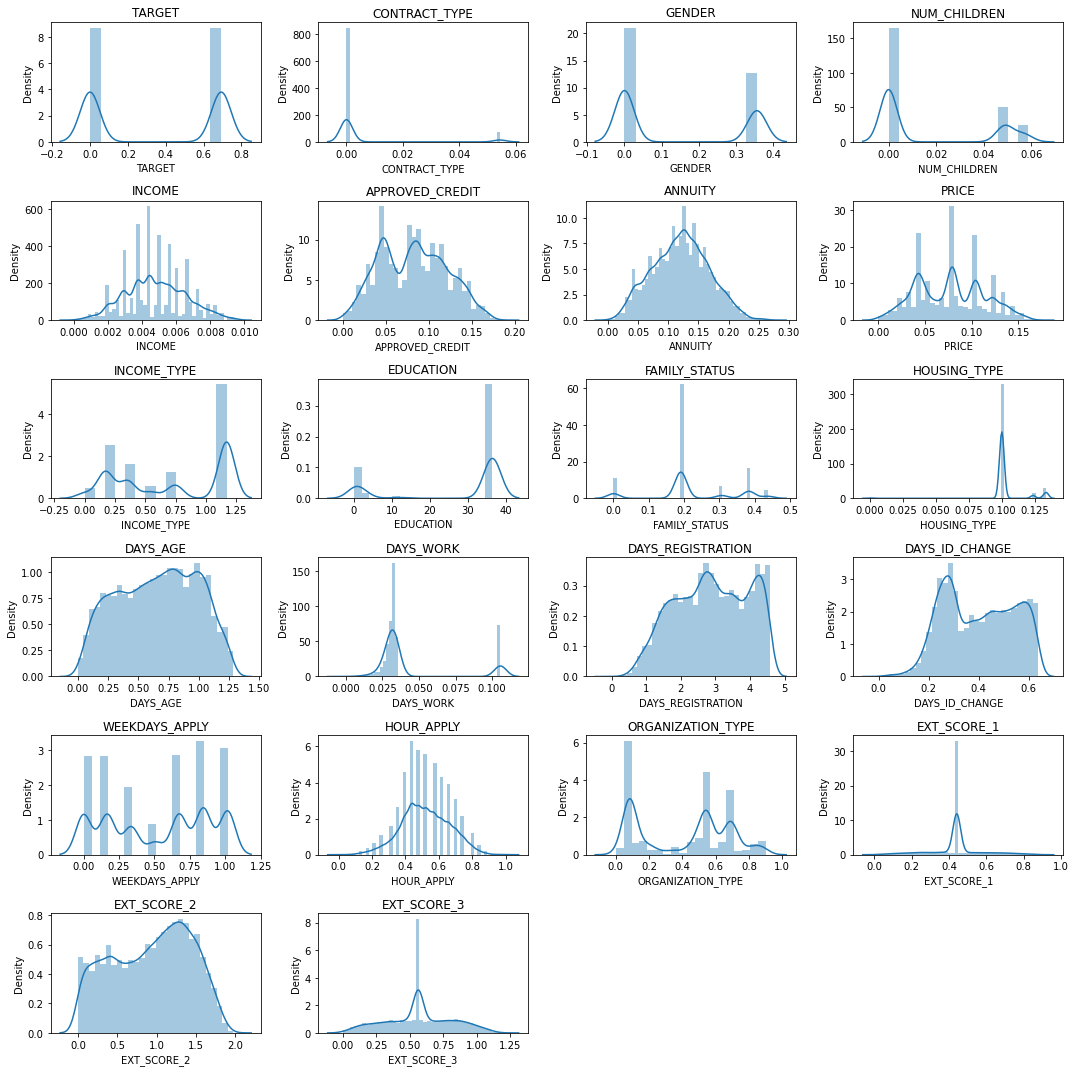

In [18]:
print("Plot Scaled and Normalize Data")
plotDataDistribute(norm_X)

In [19]:
# data transform with PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(norm_X)
pcaX_train = pca.transform(norm_X)

## ** CREATE MODELS **

In [20]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [21]:
algorithms = []
n_cluster = 3
algorithms.append(("KMEANS", KMeans(n_clusters=n_cluster)))
algorithms.append(("AHC", AgglomerativeClustering(n_clusters=n_cluster)))
# algorithms.append(("DBSCAN", DBSCAN()))
algorithms.append(("GMM", GaussianMixture(n_components=n_cluster)))

In [22]:
clusterOut = pd.DataFrame()
clusterOut["LN_ID"] = fullData.LN_ID
for name, algo in algorithms:
    cluster = algo.fit_predict(norm_X)
    clusterOut[name] = cluster
clusterOut.head(10)

LN_ID  KMEANS  AHC  GMM
10  337741       1    1    1
11  163818       0    0    0
14  297510       0    0    0
15  173482       0    0    0
32  181956       0    0    0
45  348184       1    1    1
77  153911       0    0    0
82  348532       0    0    0
87  308035       1    1    1
88  119978       0    0    0

In [23]:
for name, algo in algorithms:
    print(clusterOut[name].value_counts())
    print("=============")

0    9229
1    2936
2     179
Name: KMEANS, dtype: int64
0    9229
1    2936
2     179
Name: AHC, dtype: int64
0    7061
1    3115
2    2168
Name: GMM, dtype: int64


## ** EVALUATE MODELS **

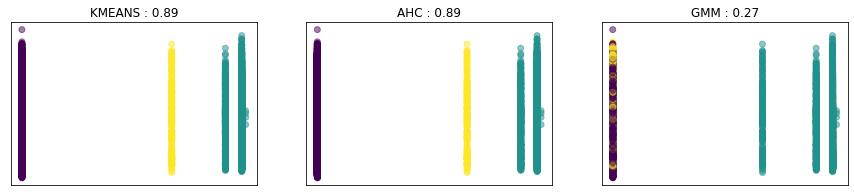

In [24]:
from sklearn.metrics.cluster import silhouette_score

silhouettes = []

fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={"xticks": (), "yticks": ()})

for ax, (name, algo) in zip(axes[0:], algorithms):
    clusters = clusterOut[name]
    silhouette = silhouette_score(norm_X, clusters)
    silhouettes.append([name, silhouette])

    ax.scatter(pcaX_train[:, 0], pcaX_train[:, 1], c=clusters, alpha=0.5)
    ax.set_title("{} : {:.2f}".format(name, silhouette))

In [25]:
# cluster data with parent data (dataTrain, dataTest)
bestAlgo = max(silhouettes, key=lambda x:x[1])[0]
clusterLabel = clusterOut[["LN_ID", bestAlgo]]

dataTrain = dataTrain.merge(clusterLabel, how="left", on="LN_ID")
dataTrain.dropna(inplace=True)

dataTest = dataTest.merge(clusterLabel, how="left", on="LN_ID")
dataTest.dropna(inplace=True)